In [1]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.factorplots import interaction_plot
from scipy import stats
from sklearn.preprocessing import StandardScaler, RobustScaler

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt


In [3]:
home = 0
if home:
    infiledir = r"C:\Users\Luzia T\UCL\WorkingFromHome\Possible_online_studies\NLP_expressive_writing\analysis\Processed_2"
    rand_dir = r"C:\Users\Luzia T\UCL\WorkingFromHome\Possible_online_studies\NLP_expressive_writing\analysis"
    writing_dir = r"C:\Users\Luzia T\UCL\WorkingFromHome\Possible_online_studies\NLP_expressive_writing\analysis\writing_data\statements"
    
else:
    infiledir = r"P:\EW_analysis_non_git\analysis\Processed_2"
    rand_dir = r"P:\EW_analysis_non_git\analysis"
    writing_dir = r"P:\EW_analysis_non_git\analysis\writing\writing_data"

output_dir = os.path.join(os.getcwd(),"output_dir_mcq")
try:
    os.makedirs(output_dir)
except OSError:
    # if directory already exists
    pass

utils

In [4]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def score_quest(in_df, out_col_name: str, items = None):
    """
    Calculate summary scores for
    questionnaires (MCQ)

    in_df:  pd.DataFrame
        input dataframe containing scores
    out_col_name:   str
        Name of output column containing summary score
    items:
        if supplied, list of items to consider
        in calculation of summary scores
    """
    if not items:
        # assume want total score
        in_df[out_col_name] = in_df.sum(axis =1 )
    else:
        in_df[out_col_name] = in_df.loc[:, items].sum(axis =1 )

def get_polarity(in_df, writing_col, polarity_type: str):
    """
    Get polarity for written statements.
    Using NLTK VADER.

    Parameters
    ----------
    in_df:  pd DataFrame
        input dataframe containing
        written statements
    writing_col:    str
        name of column containing
        statments
    polarity_type:  str
        polarity to extract
        all = get entire polarity_scores
        output as a dict
        pos = positive only
        neg = negative only
        neu = neutral only
        compound = compound
    """
    sid = SentimentIntensityAnalyzer()
    new_col_name = '_'.join(['sentiment',polarity_type, 'vader'])
    if polarity_type == 'all':   
        in_df[new_col_name] = in_df[writing_col].apply(lambda x: sid.polarity_scores(x))
    else:
        in_df[new_col_name] = in_df[writing_col].apply(lambda x: sid.polarity_scores(x)[polarity_type])
    
    return in_df

def scale_features(in_df, col_names, scaler):
    """
    Scale features.
    
    Parameters
    ----------
    in_df:  pd DataFrame
        input datatframe to operate on
    col_names: list[str]
        list of features to scale
    
    Returns
    -------
    in_df with scaled cols added.
    """
    for col in col_names:
        in_df[col+'_scaled'] = scaler.fit_transform(in_df[col].values.reshape(-1,1))
    return in_df

In [5]:
class Data_Explorer:
    def __init__(self, in_df,group_col,time_col):
        self.in_df = in_df
        self.group_col = group_col
        self.time_col = time_col
    
    def nan_zero_ids(self,response_name:str,zero_or_nan = 'nan'):
        """
        Get ids of participant with
        missing scores.

        Parameters
        ----------
        response_name: str
            feature to check nans for.
        zero_or_nan: str
            check for zero or nan values
        """
        if zero_or_nan == 'nan':
            select_ids = self.in_df.loc[self.in_df[response_name].isna(),'id'].values
        else:
            select_ids = self.in_df.loc[self.in_df[response_name]==0,'id'].values
        print(f"\nThe percentage of ids with {zero_or_nan} values on feature {response_name} is {(len(set(select_ids))/self.in_df.shape[0])*100}%.")
        if len(select_ids)>0:
            select_groups = self.in_df.loc[self.in_df.id.isin(select_ids),self.group_col].value_counts()
            print(f"\n{zero_or_nan} counts for Groups:\n{select_groups}")
        return select_ids
       
    def visualize_dist(self, var_name, distribution = None):
        """
        Draw QQ plot of var_name
        against normal (default) or gamma distribution

        Parameters
        ----------
        var_name:   str
            name of feature to plot
        distribution:
            if supplied, will plot
            var_name against gamma distribution

        """
        response_vals = self.in_df.loc[:,var_name]
        if not distribution:
            distribution = 'normal'
            fig = sm.qqplot(response_vals,line = 'q')
        else:
            distribution = distribution
            fig = sm.qqplot(response_vals,dist = stats.gamma,distargs = (4,),line = 'q')
        
        fig.suptitle(var_name)
        fig.show()
    

    def draw_kdeplot(self,ax_name, group_name, var_name: str):
        """
        Visualize univariate distributions.
        Uses Seaborn KDE plots.
        Hue = assessment time point.

        Parameters
        ----------
        ax_name:    int
            axis to plot on (for subplots)
        group_name: str
            group to plot for
        var_name:   str
            feature to plot
        
        Draws KDE plot using seaborn.
        """
        df = self.in_df.loc[
                            (self.in_df[self.group_col] == group_name),
                            var_name
                            ]
        fig = sns.kdeplot(
                            df, fill = True,
                            hue = self.in_df[self.time_col],
                            palette = 'crest',
                            ax = ax_name,
                            legend = True,
                            #warn_singular = False
                            )

    def draw_mean_trajectories(self,var_name: str, colors, markers):
        """
        Draw mean trajectories for feature var_name.
        
        Parameters
        ----------
        var_name:   str
            feature to plot
        colors: list[str]
            colors to use for plot (one per group)
        markers:    list[str]
            markers to use for pllot (one per group)
        """
        fig_mean, ax = plt.subplots(figsize=(6, 6))
        fig_mean = interaction_plot(
                                    x=self.in_df[self.time_col],
                                    trace=self.in_df[self.group_col],
                                    response=self.in_df[var_name],
                                    colors=colors,
                                    markers=markers,
                                    ms=10,
                                    ax=ax,
                                    )



In [6]:
def check_normality(data_to_check):
    """ 
    Perform Anderson-Darling test to check normality.
    H0: The data follow a normal distribution.
    Critical values are for the following significance levels:
    15%, 10%, 5%, 2.5%, 1%

    Parameters
    ----------
    data_to_check:  array-like
        data to perform normality test on.
    
    """
    res = stats.anderson(data_to_check)
    sig, crit = res.significance_level,res.critical_values
    for i in range(len(sig)):
        if res.statistic<sig[i]:
            print(f'{sig[i],crit[i]}The data follow the specified distribution: failed to reject H0.')
        else:
            print(f'{sig[i],crit[i]} The data do not follow the specified distribution: H0 rejected.')

def model_checks(data_df, columns_to_use, y_to_use,model_res, mod_type):
    """
    Model diagnostics

    Parameters
    ----------
    data_df:    pandas DataFrame
        input dataframe
    columns_to_use: str
        names of columns containing predictors to be used in the analysis
    y_to_use:   str
        names of outcome column
    model_res:    
        statsmodel results
    mod_type:   str
        modelling approach used (eg LMM, GEE)

    -------
    """
    mod_res_df = data_df.loc[:,columns_to_use]
    drop_inds = mod_res_df.loc[mod_res_df[y_to_use].isna(),:].index.values
    mod_res_df = mod_res_df.drop(labels = drop_inds, axis = 0)
    mod_res_df['fitted'] = model_res.fittedvalues
    if mod_type == 'GEE':
        mod_res_df['residuals'] = model_res.resid_deviance
        a = mod_res_df.residuals.values
        a.sort()

        # half normal plot
        fig = plt.figure()
        res = stats.probplot(a,dist = stats.halfnorm,sparams = (-0.18,10), plot=plt)
        plt.show()
        g = sns.lmplot(x = "day", y = "residuals", hue = "Group", data = mod_res_df)
        g = (g.set_axis_labels("Day [#]", "Residuals"))

    else:
        mod_res_df['residuals'] = model_res.resid
        # qq plot:
        fig = sm.qqplot(mod_res_df.residuals)

    # plotting fitted against residuals
    g = sns.lmplot(x = "fitted", y = "residuals", hue = "Group", data = mod_res_df)
    g = (g.set_axis_labels("Predicted score", "Residuals"))


def scale_scores(in_df,col_names, scaler_type):
    """ 
    Scale questionnaire scores.

    Parameters
    ----------
    in_df:  pandas Dataframe
        Dataframe to operate on.
    col_names:  list
        list of column names to operate on.
    scaler_type:  
        sklearn scaler to use (e.g. StandardScaler())
    """
    scaler = scaler_type
    for col in col_names:
        in_df[col+'_scaled'] = scaler.fit_transform(in_df[col].values.reshape(-1,1))

Prepare dataframe for analysis:

In [7]:
writing_df = pd.read_csv(os.path.join(writing_dir, 'writing_df.csv'))
mcq_df = writing_df.iloc[:,31:-5]
#mcq_df = writing_df.filter(regex = re.compile('my memory',re.IGNORECASE),axis = 1)

# reset column names so they are easier to work with.
mcq_key = [
            'clarity_dim_clear', 'clarity_visual_details','clarity_vivid',
            'clarity_sketchy_clear','clarity_order_events_confusing_clear',
            'clarity_remember_hardly_well',
            'sensory_involves_sounds','sensory_involves_touch','sensory_involves_taste',
            'sensory_involves_smell',
            'context_location_clear_vague',
            'context_spatial_arrangement_objects','context_spatial_arrangement_people',
            'memory_time_vague_clear'
            ]

mcq_df.columns = mcq_key

for col in ['id','day','Group']:
    mcq_df[col] = writing_df[col]

# set multi index for easier scoring
tot_score_df = mcq_df.set_index(['id','day'])

# select categories for MCQ scoring
cats = ['clarity','sensory','context']
for cat in cats:
    cat_vars = mcq_df.filter(like = cat, axis = 1).columns
    score_quest(tot_score_df,'_'.join(['score', cat]), list(cat_vars.values))

# add a column for total score
tot_score_items = mcq_df.columns[:-3]
score_quest(tot_score_df,'score_total',list(tot_score_items.values))

# revert back to 'regular' index bc it's easier to work with
#tot_score_df = tot_score_df.reset_index()

writing_df = writing_df.set_index(['id','day'])
writing_df = pd.concat([writing_df,tot_score_df.drop(labels = 'Group',axis = 1)], axis = 1)
writing_df = writing_df.reset_index()
tot_score_df = tot_score_df.reset_index()

Data exploration


The percentage of ids with nan values on feature score_clarity is 0.0%.

The percentage of ids with nan values on feature score_sensory is 0.0%.


<ipython-input-5-688497cb4b2b>:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-5-688497cb4b2b>:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()



The percentage of ids with nan values on feature score_context is 0.0%.

The percentage of ids with nan values on feature score_total is 0.0%.


<ipython-input-5-688497cb4b2b>:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-5-688497cb4b2b>:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()



The percentage of ids with nan values on feature memory_time_vague_clear is 3.118503118503119%.

nan counts for Groups:
EW      32
EWRE    20
CTR      8
Name: Group, dtype: int64


<ipython-input-5-688497cb4b2b>:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


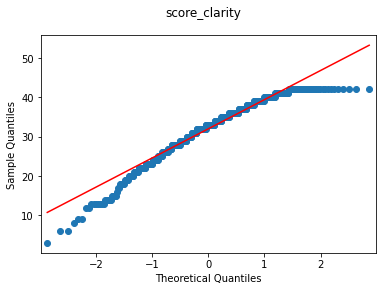

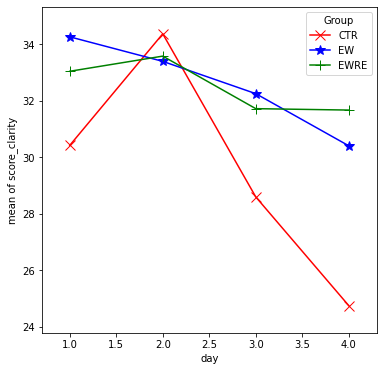

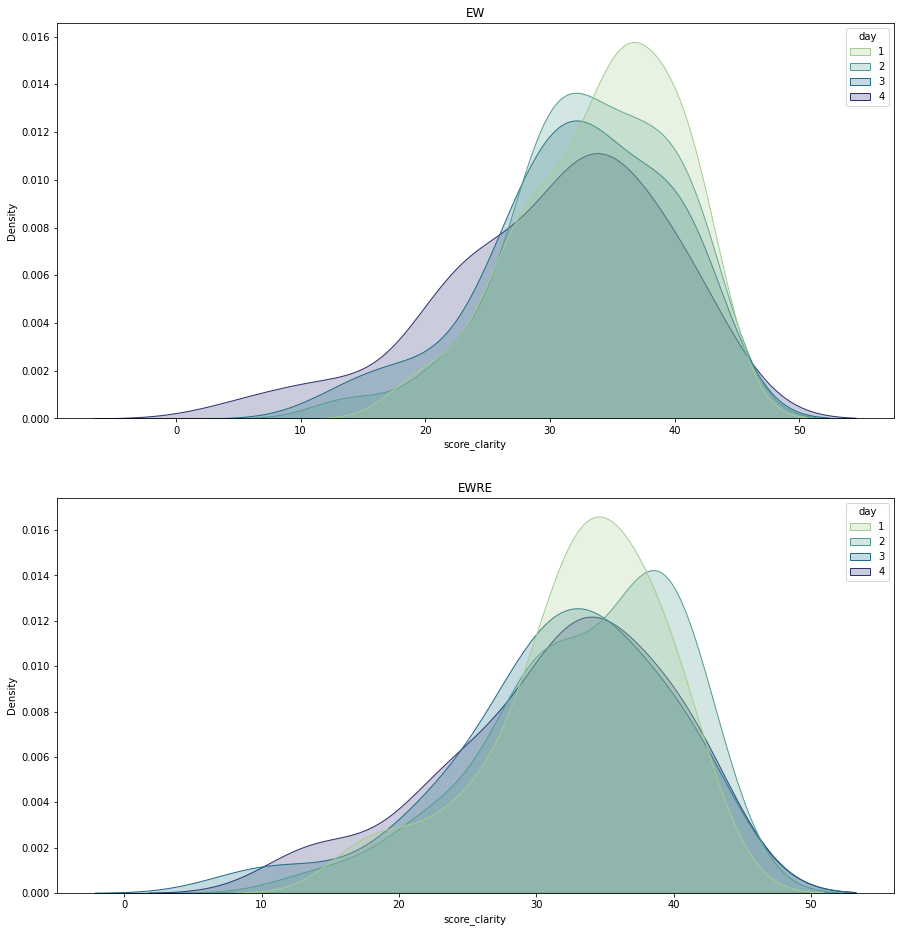

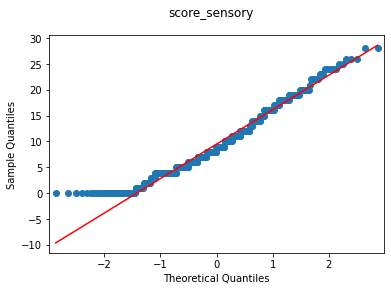

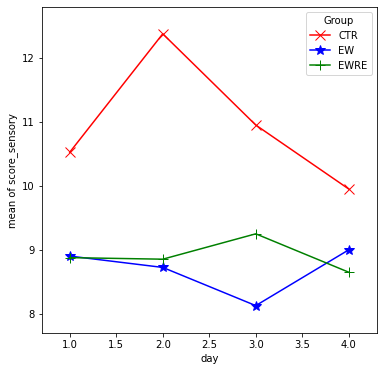

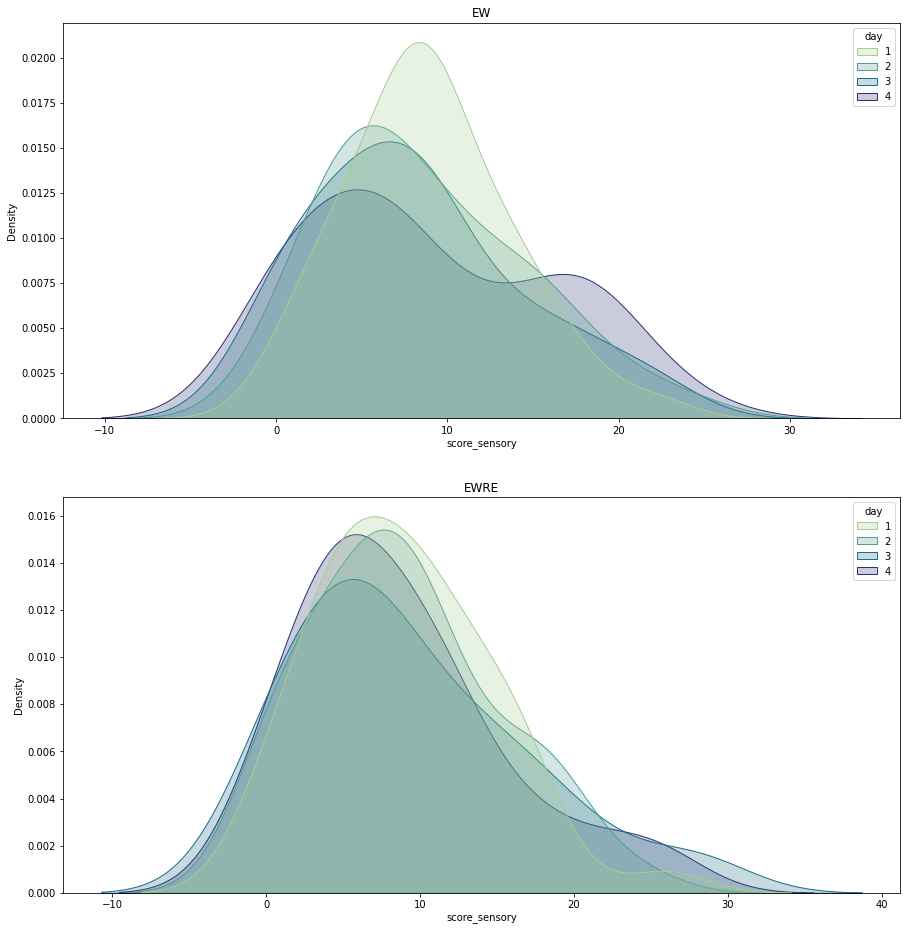

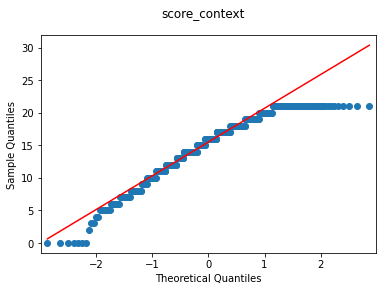

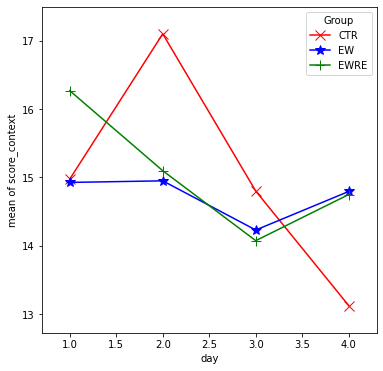

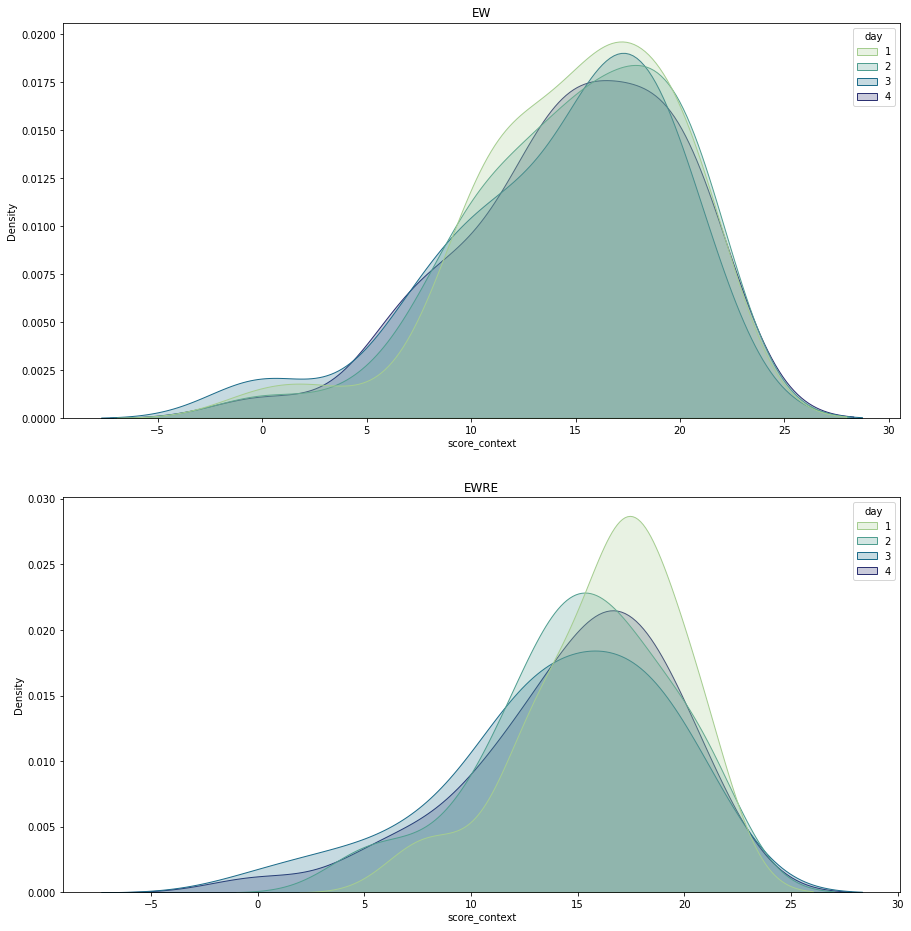

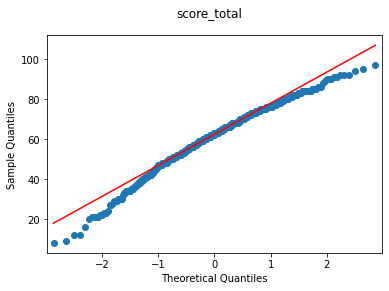

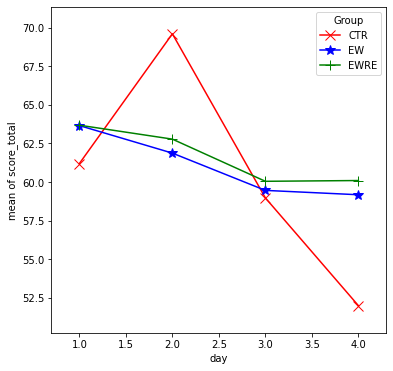

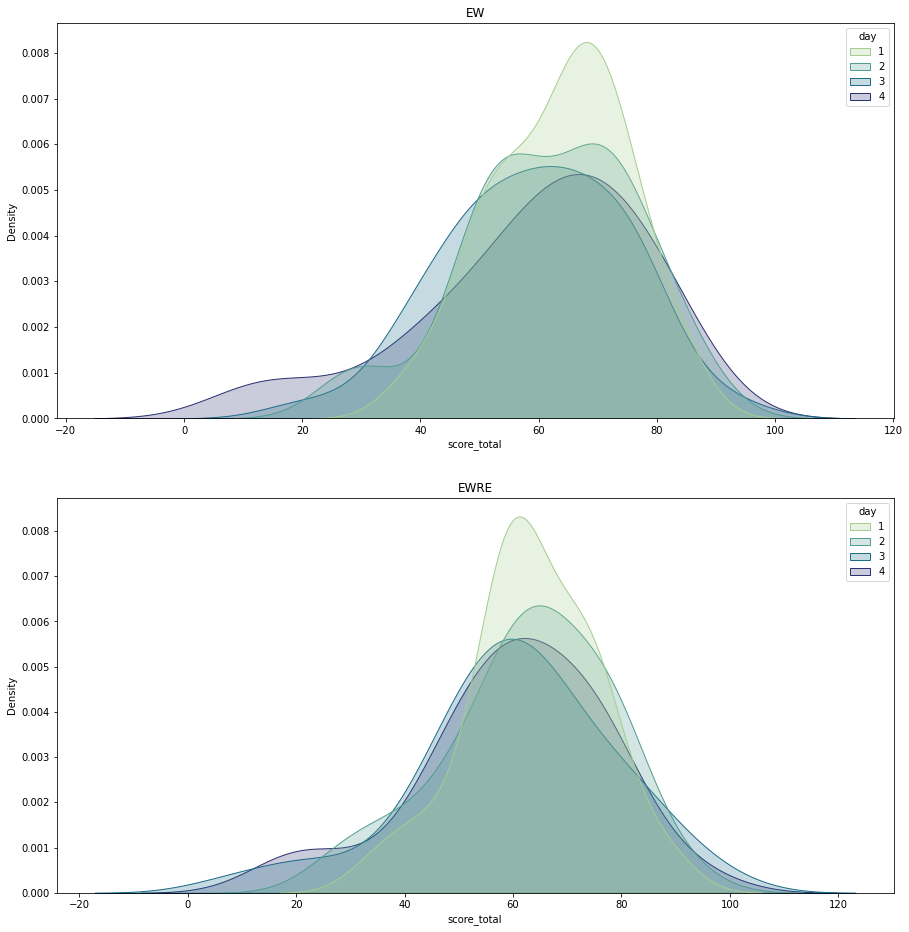

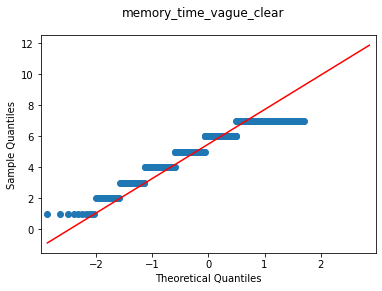

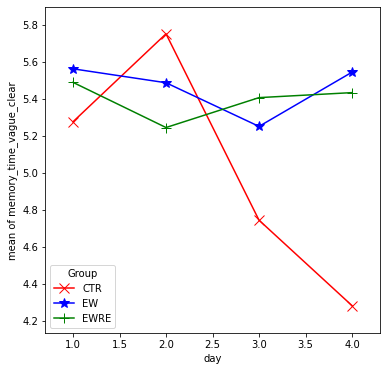

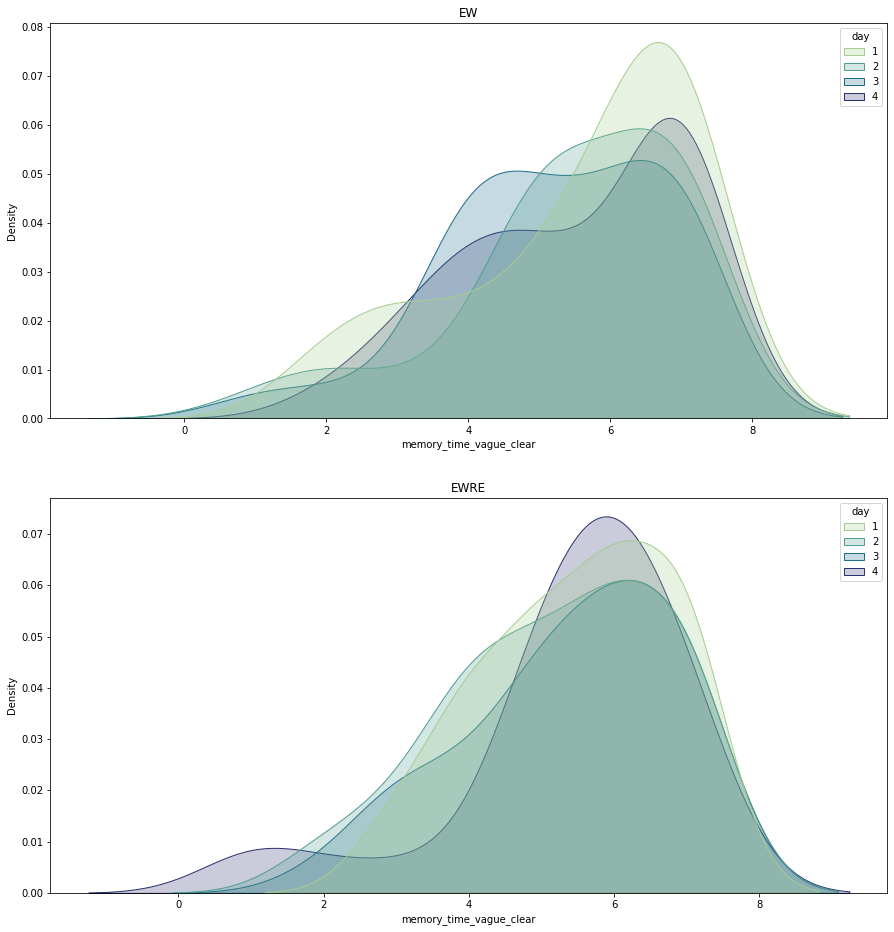

In [8]:
de = Data_Explorer(tot_score_df,'Group','day')
groups = ["EW","EWRE"]#tot_score_df.Group.unique()
cols_to_process = list(tot_score_df.filter(like = 'score',axis = 1).columns.values)
cols_to_process.extend(['memory_time_vague_clear'])
for col in cols_to_process:
    de.nan_zero_ids(col)
    de.visualize_dist(col)
    de.draw_mean_trajectories(col,['r','b','g'],['x','*','+'])
    fig,ax = plt.subplots(len(groups),1,figsize = (15,16))
    for i,group_name in enumerate(groups):
        de.draw_kdeplot(ax[i],group_name, col)
        ax[i].title.set_text(group_name)

In [9]:
# check normality
for col in cols_to_process:
    print(f"\nNow checking for score: {col}")
    check_normality(tot_score_df[col])


Now checking for score: score_clarity
(15.0, 0.571)The data follow the specified distribution: failed to reject H0.
(10.0, 0.651)The data follow the specified distribution: failed to reject H0.
(5.0, 0.781) The data do not follow the specified distribution: H0 rejected.
(2.5, 0.911) The data do not follow the specified distribution: H0 rejected.
(1.0, 1.083) The data do not follow the specified distribution: H0 rejected.

Now checking for score: score_sensory
(15.0, 0.571)The data follow the specified distribution: failed to reject H0.
(10.0, 0.651)The data follow the specified distribution: failed to reject H0.
(5.0, 0.781)The data follow the specified distribution: failed to reject H0.
(2.5, 0.911) The data do not follow the specified distribution: H0 rejected.
(1.0, 1.083) The data do not follow the specified distribution: H0 rejected.

Now checking for score: score_context
(15.0, 0.571)The data follow the specified distribution: failed to reject H0.
(10.0, 0.651)The data follow th

Modelling

In [10]:
# get polarity scores
pols = ['compound','pos','neg']
for pol in pols:
    writing_df = get_polarity(writing_df,'writing',pol)

sent_types = ['sentiment_pos_vader','sentiment_neg_vader', 'sentiment_compound_vader']
scaler = RobustScaler()
writing_df = scale_features(writing_df, sent_types, scaler)

In [20]:
sentiment_cats = ['_'.join([f,'scaled']) for f in sent_types]
cols_to_process = list(tot_score_df.filter(like = 'score',axis = 1).columns.values)
cols_to_process.extend(['memory_time_vague_clear'])
for col in cols_to_process:
    for sent in sentiment_cats:
        formula = ''.join([col,"~","C(day,Treatment(1)) * C(Group) *", sent])
        model_mcq = smf.mixedlm(
                                formula,
                                writing_df[writing_df.Group.isin(['EW','EWRE'])],
                                groups='id',missing = 'drop'
                                ).fit()
        #print(model_mcq.summary())
        with open(os.path.join(output_dir,''.join(["model_results_",col,"_",sent, ".txt"])), "w") as f:
                f.write(f"{col}:\n{model_mcq.summary()}\n")
        #model_checks(tot_score_df[tot_score_df.Group.isin(['EW','EWRE'])],
     #              ['Group','day',col],col,model_mcq,'LMM')

In [18]:
for col in cols_to_process:
    formula = ''.join([col,"~","C(day,Treatment(1)) + C(Group)"])
    model_mcq = smf.mixedlm(
                            formula,
                            writing_df[writing_df.Group.isin(['EW','EWRE'])],
                            groups='id',missing = 'drop'
                            ).fit()
        #print(model_mcq.summary())
    with open(os.path.join(output_dir,''.join(["model_results_nosent_nointer",col, ".txt"])), "w") as f:
            f.write(f"{col}:\n{model_mcq.summary()}\n")

In [46]:
fam = sm.families.Gaussian()
ind = sm.cov_struct.Independence()
for col in cols_to_process:
    for sent in sentiment_cats:
        formula = ''.join([col,"~","C(day,Treatment(1)) * C(Group) *", sent])
        model_mcq = smf.gee(
                                formula,
                                "id",
                                writing_df[writing_df.Group.isin(['EW','EWRE'])],
                                cov_struct = ind,
                                family = fam,
                                missing = 'drop'
                                ).fit()
        #print(model_mcq.summary())
        with open(os.path.join(output_dir,''.join(["model_results_",col,"_",sent, ".txt"])), "w") as f:
                f.write(f"{col}:\n{model_mcq.summary()}\n")

In [48]:
fam = sm.families.Gaussian()
ind = sm.cov_struct.Independence()
for col in cols_to_process:
    for sent in sentiment_cats:
        formula = ''.join([col,"~","C(day,Treatment(1)) + C(Group)"])
        model_mcq = smf.gee(
                                formula,
                                "id",
                                writing_df[writing_df.Group.isin(['EW','EWRE'])],
                                cov_struct = ind,
                                family = fam,
                                missing = 'drop'
                                ).fit()
        #print(model_mcq.summary())
        with open(os.path.join(output_dir,''.join(["model_results_add",col, ".txt"])), "w") as f:
                f.write(f"{col}:\n{model_mcq.summary()}\n")

In [ ]:
# store mcq scores as csv file
tot_score_df.to_csv(os.path.join(output_dir,'mcq_scored.csv'))